In [141]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

In [142]:
def load_pickled_dictionaries(directory):
    files = os.listdir(directory)
    data_by_imp_var = {}

    for file in files:
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
    
            base_name = file[:-4] 
            parts = base_name.split('_', 1) 
            if len(parts) == 2:
                imp, var = parts
            else:
                raise ValueError(f"Filename {file} does not follow expected pattern.")

            if imp not in data_by_imp_var:
                data_by_imp_var[imp] = {}
            data_by_imp_var[imp][var] = data

    return data_by_imp_var

In [24]:
directory = "./PklDicts"
loaded_data = load_pickled_dictionaries(directory)

In [5]:
loaded_data['remove']['split-loc-(month-circ)']['Cobar']['KNN']

[{'accuracy': 0.9065420560747663,
  'no_precision': 0.9381443298969072,
  'no_recall': 0.9578947368421052,
  'yes_precision': 0.6,
  'yes_recall': 0.5},
 {'accuracy': 0.9252336448598131,
  'no_precision': 0.9387755102040817,
  'no_recall': 0.9787234042553191,
  'yes_precision': 0.7777777777777778,
  'yes_recall': 0.5384615384615384},
 {'accuracy': 0.8878504672897196,
  'no_precision': 0.91,
  'no_recall': 0.9680851063829787,
  'yes_precision': 0.5714285714285714,
  'yes_recall': 0.3076923076923077},
 {'accuracy': 0.8878504672897196,
  'no_precision': 0.9019607843137255,
  'no_recall': 0.9787234042553191,
  'yes_precision': 0.6,
  'yes_recall': 0.23076923076923078},
 {'accuracy': 0.9150943396226415,
  'no_precision': 0.9207920792079208,
  'no_recall': 0.9893617021276596,
  'yes_precision': 0.8,
  'yes_recall': 0.3333333333333333}]

In [135]:
imputations = ['remove', 'reg-class', 'mean-mode', 'hybrid']
variations = ['drop-loc+date', 'drop-loc-(month-disc)', 'drop-loc-(month-circ)', 'drop-date-(lat-long)', 
              'disc-month-lat-long', 'disc-month+loc', 'month-circ-lat-long', 'month-circ-lat-long-wind-circ', 
              'split-loc-(drop-date)', 'split-season-(drop-loc)', #'split-loc+season',
              'split-loc-(month-disc)', 'split-loc-(month-circ)', 'split-season-(lat-long)',
              'rm-temp1', 'rm-temp2', 'rm-pres1', 'rm-pres2', 'rm-hum1', 'rm-hum2', 'rm-1', 'rm-2', 'rm-3', 'rm-4',
               'rm-rain', 'rm-all-but-rain', 'rm-all-but-rain+temp']
models = ['RandomForest', 'KNN', 'DecisionTree', 'SGD']

In [8]:
locs = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston', 'AliceSprings', 'Darwin', 'Katherine', 'Uluru']
rm_locs = ['Cobar', 'CoffsHarbour', 'Moree', 'NorfolkIsland', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Canberra', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 'Portland', 'Watsonia', 'Brisbane', 'Cairns', 'Townsville', 'MountGambier', 'Nuriootpa', 'Woomera', 'PerthAirport', 'Perth', 'Hobart', 'AliceSprings', 'Darwin']
seasons = [0.0, 0.3333333333333333, 0.6666666666666666, 1.0]


In [19]:
def means_by_baselearner(m, loaded_data, imputations, variations):
    locs = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston', 'AliceSprings', 'Darwin', 'Katherine', 'Uluru']
    rm_locs = ['Cobar', 'CoffsHarbour', 'Moree', 'NorfolkIsland', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Canberra', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 'Portland', 'Watsonia', 'Brisbane', 'Cairns', 'Townsville', 'MountGambier', 'Nuriootpa', 'Woomera', 'PerthAirport', 'Perth', 'Hobart', 'AliceSprings', 'Darwin']
    seasons = [0.0, 0.3333333333333333, 0.6666666666666666, 1.0]
    
    means = []
    for imp in imputations:
        lst = []
        for var in variations:
            accuracies = []
            if 'split' in var:
                if 'split-loc' in var:
                    if imp == 'remove': ls = rm_locs
                    else: ls = locs
                    for loc in ls:
                        for i in range(5):
                            accuracies.append(loaded_data[imp][var][loc][m][i]['accuracy'])
                elif 'split-season' in var:
                    for season in seasons:
                        for i in range(5):
                            accuracies.append(loaded_data[imp][var][season][m][i]['accuracy'])
                mean = sum(accuracies)/len(accuracies)
                lst.append(mean)
                        
            else:
                for i in range(5):
                    accuracies.append(loaded_data[imp][var][m][i]['accuracy'])
                mean = sum(accuracies)/len(accuracies)
                lst.append(mean)
        means.append(lst)
    
    data = {'variation': variations, 'remove': means[0], 'reg-class': means[1], 'mean-mode': means[2], 'hybrid': means[3]}
    means_df = pd.DataFrame(data=data)
    
    imps = ['remove', 'reg-class', 'mean-mode', 'hybrid']
    alls = []
    for i, row in means_df.iterrows():
        alls.append(sum([row[i] for i in imps])/4)
    means_df['all'] = alls
    
    leftover = means_df[-3:]
    means_df = means_df[:-3]
    
    totals = [0, 0, 0, 0]
    for i, row in means_df.iterrows():
        for i in range(4):
            totals[i] += row[imps[i]]
    
    n = len(means_df)
    new_row = {'variation': 'all', 'remove': totals[0]/n, 'reg-class': totals[1]/n, 'mean-mode': totals[2]/n, 'hybrid': totals[3]/n, 'all': sum(totals)/n/4}
    means_df.loc[n] = new_row
    
    return means_df

In [17]:
# Run Friedman tests on four groups, one for each model
# Run test on big groups for all four imputation methods
# Run another Friedman test on all variations (without rm-rain, rm-all-but-rain, rm-all-but-rain+temp)
# Compare each of the following to c

In [93]:
def run_Friedman(lst_of_lsts):
    stat, p = friedmanchisquare(*lst_of_lsts)
    print("p-value:", p)
    if p < 0.05: return False
    else: return True

In [92]:
run_Friedman([[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 50, 800], [1, 2, 3, 4, 5, 6]])

p-value 0.1353352832366127


True

In [55]:
loaded_data['hybrid']['drop-loc+date'].keys()

dict_keys(['RandomForest', 'KNN', 'DecisionTree', 'SGD'])

In [86]:
def get_all_imps(data, imputations, variations, models):
    locs = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston', 'AliceSprings', 'Darwin', 'Katherine', 'Uluru']
    rm_locs = ['Cobar', 'CoffsHarbour', 'Moree', 'NorfolkIsland', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Canberra', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 'Portland', 'Watsonia', 'Brisbane', 'Cairns', 'Townsville', 'MountGambier', 'Nuriootpa', 'Woomera', 'PerthAirport', 'Perth', 'Hobart', 'AliceSprings', 'Darwin']
    seasons = [0.0, 0.3333333333333333, 0.6666666666666666, 1.0]
    
    lst = []
    for imp in imputations:
        mini = []
        for var in variations:
            if 'split' in var:
                if 'split-loc' in var:
                    if imp == 'remove': ls = rm_locs
                    else: ls = locs
                    all_accuracies = []
                    for loc in ls:
                        one_lst = []
                        for m in models:
                            for i in range(5):
                                one_lst.append(data[imp][var][loc][m][i]['accuracy'])
                        all_accuracies.append(sorted(one_lst))
                    for i in range(len(one_lst)):
                        temp = [all_accuracies[j][i] for j in range(len(ls))]
                        mini.append(sum(temp)/len(temp))

                elif 'split-season' in var:
                    for season in seasons:
                        for m in models:
                            for i in range(5):
                                mini.append(data[imp][var][season][m][i]['accuracy'])
            else:
                for m in models:
                    for i in range(5):
                        mini.append(data[imp][var][m][i]['accuracy'])
        lst.append(mini)
    return lst

In [94]:
lst = get_all_imps(loaded_data, imputations, variations, models)

In [95]:
run_Friedman(lst)

p-value: 3.4568526709398048e-177


False

In [99]:
by_baselearner = {}
for m in models:
    df = means_by_baselearner(m, loaded_data, imputations, variations)
    by_baselearner[m] = df

In [173]:
maxes = []
mins = []
meanss = []
accs = ['accuracy', 'no_precision', 'no_recall', 'yes_precision', 'yes_recall']
for acc in accs:
    means = []
    for imp in imputations:
        lst = []
        for var in variations:
            accuracies = []
            if 'split' in var:
                if 'split-loc' in var:
                    if imp == 'remove': ls = rm_locs
                    else: ls = locs
                    for loc in ls:
                        for m in models:
                            for i in range(5):
                                accuracies.append(loaded_data[imp][var][loc][m][i][acc])
                elif 'split-season' in var:
                    for season in seasons:
                        for m in models:
                            for i in range(5):
                                accuracies.append(loaded_data[imp][var][season][m][i][acc])
                mean = sum(accuracies)/len(accuracies)
                lst.append(mean)
                        
            else:
                for m in models:
                    for i in range(5):
                        accuracies.append(loaded_data[imp][var][m][i][acc])
                mean = sum(accuracies)/len(accuracies)
                lst.append(mean)
        means.append(lst)
    
    data = {'variation': variations, 'remove': means[0], 'reg-class': means[1], 'mean-mode': means[2], 'hybrid': means[3]}
    means_df = pd.DataFrame(data=data)
    og_means_df = means_df.copy()
    
    #display(means_df)
    
    imps = ['remove', 'reg-class', 'mean-mode', 'hybrid']
    alls = []
    for i, row in means_df.iterrows():
        alls.append(sum([row[i] for i in imps])/4)
    means_df['all'] = alls
    
    leftover = means_df[-3:]
    means_df = means_df[:-3]

    big_lst = list(means_df['remove']) + list(means_df['reg-class']) + list(means_df['mean-mode']) + list(means_df['hybrid'])
    maxes.append(max(big_lst))
    mins.append(min(big_lst))
    meanss.append(sum(big_lst)/len(big_lst))
    

data = {'metric': accs, 
        'min' :mins, 'mean': meanss, 'max': maxes}
    
display(pd.DataFrame(data=data))

,metric,min,mean,max
0,accuracy,0.813540,0.843823,0.853430
1,no_precision,0.848500,0.862795,0.874305
2,no_recall,0.915751,0.949809,0.956826
3,yes_precision,0.693918,0.737016,0.753249
4,yes_recall,0.411174,0.470720,0.517099


In [138]:
acc = 'accuracy'
means = []
for imp in imputations:
    lst = []
    for var in variations:
        accuracies = []
        if 'split' in var:
            if 'split-loc' in var:
                if imp == 'remove': ls = rm_locs
                else: ls = locs
                for loc in ls:
                    for m in models:
                        for i in range(5):
                            accuracies.append(loaded_data[imp][var][loc][m][i][acc])
            elif 'split-season' in var:
                for season in seasons:
                    for m in models:
                        for i in range(5):
                            accuracies.append(loaded_data[imp][var][season][m][i][acc])
            mean = sum(accuracies)/len(accuracies)
            lst.append(mean)
                    
        else:
            for m in models:
                
                for i in range(5):
                    accuracies.append(loaded_data[imp][var][m][i][acc])
            mean = sum(accuracies)/len(accuracies)
            lst.append(mean)
    means.append(lst)

data = {'variation': variations, 'remove': means[0], 'reg-class': means[1], 'mean-mode': means[2], 'hybrid': means[3]}
means_df = pd.DataFrame(data=data)
og_means_df = means_df.copy()

display(means_df)

imps = ['remove', 'reg-class', 'mean-mode', 'hybrid']
alls = []
for i, row in means_df.iterrows():
    alls.append(sum([row[i] for i in imps])/4)
means_df['all'] = alls

leftover = means_df[-3:]
means_df = means_df[:-3]

totals = [0, 0, 0, 0]
for i, row in means_df.iterrows():
    for i in range(4):
        totals[i] += row[imps[i]]

n = len(means_df)
new_row = {'variation': 'all', 'remove': totals[0]/n, 'reg-class': totals[1]/n, 'mean-mode': totals[2]/n, 'hybrid': totals[3]/n, 'all': sum(totals)/n/4}
means_df.loc[n] = new_row

display(means_df)
display(leftover)

,variation,remove,reg-class,mean-mode,hybrid
0,drop-loc+date,0.851529,0.841596,0.843292,0.842788
1,drop-loc-(month-disc),0.851396,0.842360,0.843125,0.842527
2,drop-loc-(month-circ),0.850913,0.842128,0.842378,0.842227
3,drop-date-(lat-long),0.853430,0.844330,0.844001,0.844516
4,disc-month-lat-long,0.852605,0.818180,0.813540,0.831669
5,disc-month+loc,0.850563,0.842552,0.842487,0.842708
6,month-circ-lat-long,0.852437,0.843665,0.843271,0.843941
7,month-circ-lat-long-wind-circ,0.850359,0.841138,0.840280,0.841318
8,split-loc-(drop-date),0.847864,0.843505,0.844586,0.844816
9,split-season-(drop-loc),0.849461,0.840693,0.840624,0.840299


,variation,remove,reg-class,mean-mode,hybrid,all
0,drop-loc+date,0.851529,0.841596,0.843292,0.842788,0.844801
1,drop-loc-(month-disc),0.851396,0.842360,0.843125,0.842527,0.844852
2,drop-loc-(month-circ),0.850913,0.842128,0.842378,0.842227,0.844411
3,drop-date-(lat-long),0.853430,0.844330,0.844001,0.844516,0.846569
4,disc-month-lat-long,0.852605,0.818180,0.813540,0.831669,0.828999
5,disc-month+loc,0.850563,0.842552,0.842487,0.842708,0.844578
6,month-circ-lat-long,0.852437,0.843665,0.843271,0.843941,0.845829
7,month-circ-lat-long-wind-circ,0.850359,0.841138,0.840280,0.841318,0.843274
8,split-loc-(drop-date),0.847864,0.843505,0.844586,0.844816,0.845193
9,split-season-(drop-loc),0.849461,0.840693,0.840624,0.840299,0.842769


,variation,remove,reg-class,mean-mode,hybrid,all
23,rm-rain,0.852769,0.844583,0.844359,0.844766,0.846619
24,rm-all-but-rain,0.779741,0.775819,0.775819,0.775819,0.776799
25,rm-all-but-rain+temp,0.800253,0.797304,0.797530,0.797393,0.798120


In [96]:
run_Friedman([means_df['remove'], means_df['reg-class'], means_df['mean-mode'], means_df['hybrid']])

p-value: 3.740558480988826e-10


False

In [97]:
lst = []
for i, row in means_df.iterrows():
    lst.append([row['remove'], row['reg-class'], row['mean-mode'], row['hybrid']])

In [101]:
run_Friedman(lst)
# GOOD RESULT: DIFFERENCE BETWEEN STATISTICAL SIGNIFICANCE AND PRACTICAL SIGNIFICANCE

p-value: 8.156813459166303e-07


False

In [103]:
m = 'KNN'
lst = []
for m in models:
    mini = []
    for i, row in by_baselearner[m].iterrows():
        for imp in imputations:
            mini.append(row[imp])
    lst.append(mini)
    

In [104]:
run_Friedman(lst)

p-value: 4.789642489598879e-45


False

In [147]:
def run_Wilcoxon(var1, var2, means_df):
    for i, row in og_means_df.iterrows():
        if row['variation'] == var1: lst1 = [row[imp] for imp in imputations]
        if row['variation'] == var2: lst2 = [row[imp] for imp in imputations]
    stat, p = wilcoxon(lst1, lst2)
    print("p-value:", p)
    if p < 0.05: return False
    else: return True

In [148]:
run_Wilcoxon('disc-month-lat-long', 'rm-rain', means_df)

p-value: 0.125


True

In [165]:
for v in ['rm-rain', 'rm-all-but-rain', 'rm-all-but-rain+temp']:
    print(run_Wilcoxon('disc-month-lat-long', v, means_df))

p-value: 0.125
True
p-value: 0.125
True
p-value: 0.125
True


In [163]:
def run_test(variations, means_df):
    lsts = [None]*len(variations)
    for i, row in og_means_df.iterrows():
        for v in range(len(variations)):
            if row['variation'] == variations[v]:
                lsts[v] = [row[imp] for imp in imputations]
    return run_Friedman(lsts)

In [164]:
run_test(['rm-rain', 'rm-all-but-rain', 'rm-all-but-rain+temp', 'disc-month-lat-long'], means_df)

p-value: 0.007383160505359769


False

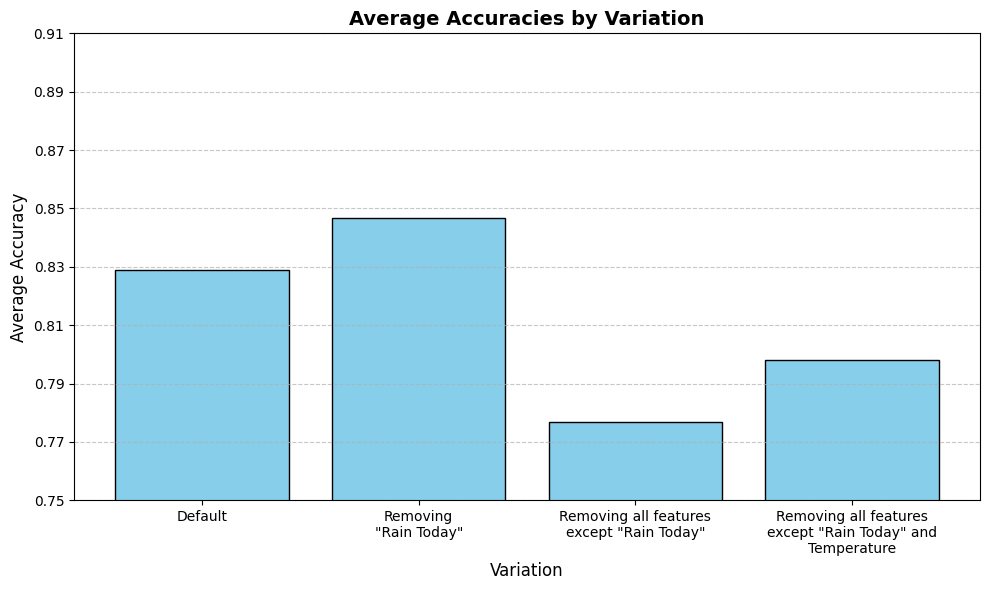

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    'variation': [
        'Default', 
        'Removing\n"Rain Today"', 
        'Removing all features\nexcept "Rain Today"', 
        'Removing all features\nexcept "Rain Today" and\nTemperature'
    ],
    'accuracy': [0.828999, 0.846619, 0.776799, 0.798120] 
}

# Figure settings
plt.figure(figsize=(10, 6))
plt.bar(data['variation'], data['accuracy'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('Variation', fontsize=12)
plt.ylabel('Average Accuracy', fontsize=12)
plt.title('Average Accuracies by Variation', fontsize=14, fontweight='bold')

# Y-axis limits and ticks
plt.ylim([0.75, 0.90])
plt.yticks(np.arange(0.75, 0.91, 0.02), fontsize=10)

# X-axis settings
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
